In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from aging.behavior.syllables import relabel_by_usage, assign_onsets
import colorcet as cc
from pathlib import Path

In [2]:
def age_map(string) -> int:
    '''returns age in weeks'''
    if '3m' in string:
        return 12
    if '6m' in string:
        return 24
    if '9m' in string:
        return 35
    if '12m' in string:
        return 52
    if '18m' in string:
        return 72
    if '22m' in string:
        return 90
    if '3w' in string:
        return 3
    if '5w' in string:
        return 5
    if '7w' in string:
        return 7
    if '9w' in string:
        return 9
    else:
        return int(string[:2])

In [3]:
def age_map_fun(age):
    try:
        return int(age.split("w")[0])
    except ValueError:
        return {"3": 12, "6": 24, "9": 35, "12": 52, "18": 72, "22": 90}[
            age.split("m")[0]
        ]

## upload data and housekeeping

In [4]:
## get syllable maps from male ontogeny
df_temp = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_males_syllable_df_v00.parquet')
df_temp,usage_map = relabel_by_usage(df_temp, return_map=True)

In [5]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_females_syllable_df_v00.parquet')

In [6]:
# relabel syllables by usage and add age
#df = relabel_by_usage(df, return_map=False)
df = assign_onsets(df)
# remove CRl mice
df = df[~df['session_name'].str.contains('CRL')]
df['relabeled_syllables'] = df['syllables'].map(usage_map)
#df['age'] = df['age'].map(age_map)

In [7]:
unique_ages = df['age'].unique()
age_map = dict(zip(unique_ages, map(age_map_fun, unique_ages)))
df['age'] = df['age'].map(age_map).astype('int16[pyarrow]')

In [8]:
df.age.unique()

<ArrowExtensionArray>
[  5,  44,  48,  78,  72,   9,  16,  90,  80,  12,  84,   7,  24,  52,  64,
  56,  68,  60,  40,  36,   3,  35, 127,  20,  32]
Length: 25, dtype: int16[pyarrow]

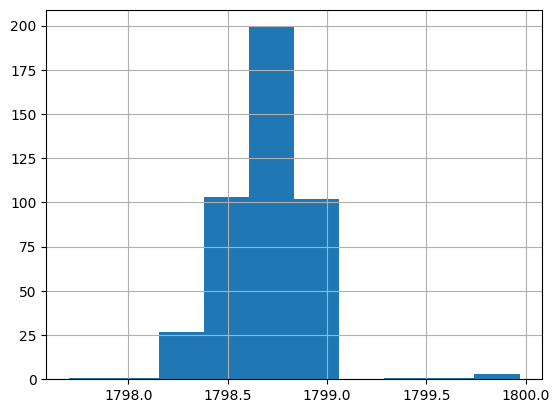

In [9]:
# clean up the data by removing short sessions
t = 600
session_length = df.groupby("uuid", sort=False)['timestamps'].max()
remove_uuids = session_length[session_length < t].index
session_length.hist()
df = df[~df['uuid'].isin(remove_uuids)]

In [10]:
# remove duplicated files due to cleaning extractions
new_df = []
for (date, subject), _df in df.groupby(['date', 'subject_name'], sort=False):
    if _df['uuid'].nunique() > 1:
        _df = _df[_df['file'].str.contains('proc_cleaned')]
    new_df.append(_df)
    
df = pd.concat(new_df)

In [11]:
# computer usage

In [12]:
usage_df = df.query('onsets').groupby(['age', 'subject_name', 'session_name','uuid','date'])['relabeled_syllables'].value_counts(normalize=True)
usage_df.name = 'usage'
usage_df = usage_df.reset_index()
usage_mtx = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age','subject_name','session_name', 'uuid','date']).fillna(0)

In [13]:
v = df.groupby(['age','subject_name','session_name', 'uuid','date']).velocity_2d_mm.mean()
usage_mtx['velocity'] = v
usage_mtx.set_index('velocity', append=True, inplace=True)
usage_mtx = usage_mtx.drop(35, level='age')

In [14]:
from collections import Counter
Counter(usage_mtx.index.get_level_values(0))

Counter({3: 24,
         5: 24,
         7: 24,
         9: 24,
         12: 24,
         24: 24,
         52: 24,
         72: 24,
         16: 16,
         20: 16,
         32: 16,
         36: 16,
         40: 16,
         44: 16,
         48: 16,
         56: 16,
         60: 16,
         64: 16,
         68: 16,
         78: 16,
         84: 16,
         80: 8,
         90: 8,
         127: 6})

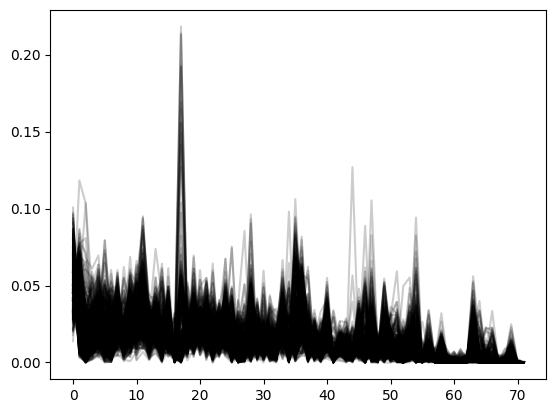

In [15]:
plt.plot(usage_mtx.values.T, c='k', alpha=0.2);

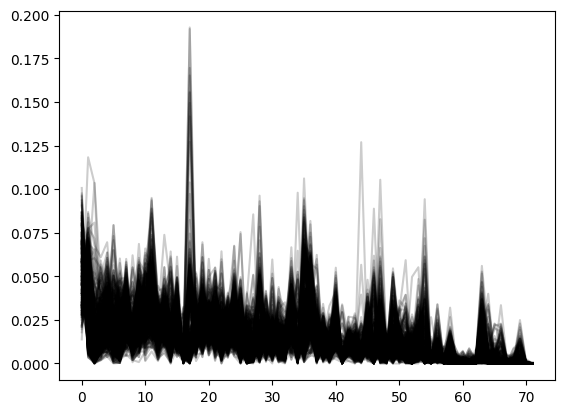

In [16]:
# remove sessions with abnormally high syllable usage
us = 0.2
usage_mtx = usage_mtx[~(usage_mtx > us).any(axis=1)]
plt.plot(usage_mtx.values.T, c='k', alpha=0.2);

In [17]:
um = usage_mtx.reset_index()
from collections import Counter
Counter(um.age)

Counter({3: 24,
         5: 24,
         7: 24,
         9: 24,
         12: 24,
         24: 24,
         52: 24,
         72: 24,
         16: 16,
         20: 16,
         32: 16,
         36: 16,
         40: 16,
         44: 16,
         56: 16,
         64: 16,
         68: 16,
         78: 16,
         84: 16,
         60: 15,
         48: 14,
         80: 8,
         90: 8,
         127: 6})

In [18]:
data_folder = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07')
usage_mtx.to_parquet(data_folder / "ontogeny_females_clean_v1.parquet", engine='pyarrow') 

In [19]:
#get random 16 mice per age
#get random 16 mice for ages in which there are more than 16 mice
n=16
usage_mtx = usage_mtx.groupby('age').apply(lambda x: x.sample(n=n,replace=False) if len(x)>n else x.sample(n=len(x),replace=False)).reset_index(level=0, drop=True)

In [20]:
um = usage_mtx.reset_index()
from collections import Counter
Counter(um.age)

Counter({3: 16,
         5: 16,
         7: 16,
         9: 16,
         12: 16,
         16: 16,
         20: 16,
         24: 16,
         32: 16,
         36: 16,
         40: 16,
         44: 16,
         52: 16,
         56: 16,
         64: 16,
         68: 16,
         72: 16,
         78: 16,
         84: 16,
         60: 15,
         48: 14,
         80: 8,
         90: 8,
         127: 6})

In [21]:
data_folder = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07')
usage_mtx.to_parquet(data_folder / "ontogeny_females_clean_v2.parquet", engine='pyarrow') 